In [21]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import random 
import torch 
from torch import nn, optim 
from torch.nn import functional as F 
from torchvision import transforms as T 
from torch.utils.data import DataLoader, Dataset, random_split 

import PIL
from PIL import Image 

from jupyterthemes import jtplot 
jtplot.style()

# GPU

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Dataset and Dataloader 

In [23]:
#PATH = 
TRAIN_PATH = r"C:\Users\ortma\Desktop\modelos_mios_pruebas\train\train"
TRAIN_MASK_PATH = r"C:\Users\ortma\Desktop\modelos_mios_pruebas\train_masks\train_masks"
TEST_PATH = r"C:\Users\ortma\Desktop\modelos_mios_pruebas\test\test"

## Dataset

In [24]:
class Car_Dataset(Dataset): 
    def __init__(self, data, masks =None, img_transforms=None, mask_transforms=None):
        '''
        data - train data path 
        mask - train mask path
        '''
        self.train_data = data
        self.train_masks = masks
        
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        self.images = sorted(os.listdir(self.train_data)) #lista de todos los elementos que se encuentran en la carpeta
        self.masks = sorted(os.listdir(self.train_masks))
    
    def __len__(self):
        if self.train_masks is not None: 
            assert len(self.images)==len(self.masks), 'not the same number of images and masks'
        return len(self.images)

    def __getitem__(self, idx): 
        image_name = os.path.join(self.train_data, self.images[idx]) #obtenemos la ruta de la imagen indexada
        img = Image.open(image_name) #cargamos la imagen
        trans = T.ToTensor()
        if self.img_transforms is not None: 
            img = self.img_transforms(img)
        else: 
            img = trans(img)
            
        if self.train_masks is not None: 
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)
            if self.mask_transforms is not None: 
                mask = self.mask_transforms(mask)
            else: 
                mask = trans(mask)
            mask_max = mask.max().item() #lo normalizo
            mask /= mask_max

        else: 
            return img
            
        return img, mask
        


        

## Transformaciones 

In [25]:
transform_data = T.Compose([
                T.Resize([224,224]),
                T.ToTensor()])

## DataLoader

In [26]:
full_dataset = Car_Dataset(TRAIN_PATH, TRAIN_MASK_PATH, img_transforms=transform_data, mask_transforms=transform_data)

BATCH_SIZE = 32
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset)-TRAIN_SIZE

print(TRAIN_SIZE, VAL_SIZE)

4070 1018


In [27]:
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])

train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True )
val_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle=True )

imgs, masks = next(iter(train_loader))

print(imgs.shape, masks.shape)



torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])


In [28]:
for i , (x,y) in enumerate(train_loader):
    print(i, x.shape, y.shape)
    if i == 9: break 

0 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
1 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
2 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
3 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
4 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
5 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
6 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
7 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
8 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
9 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])


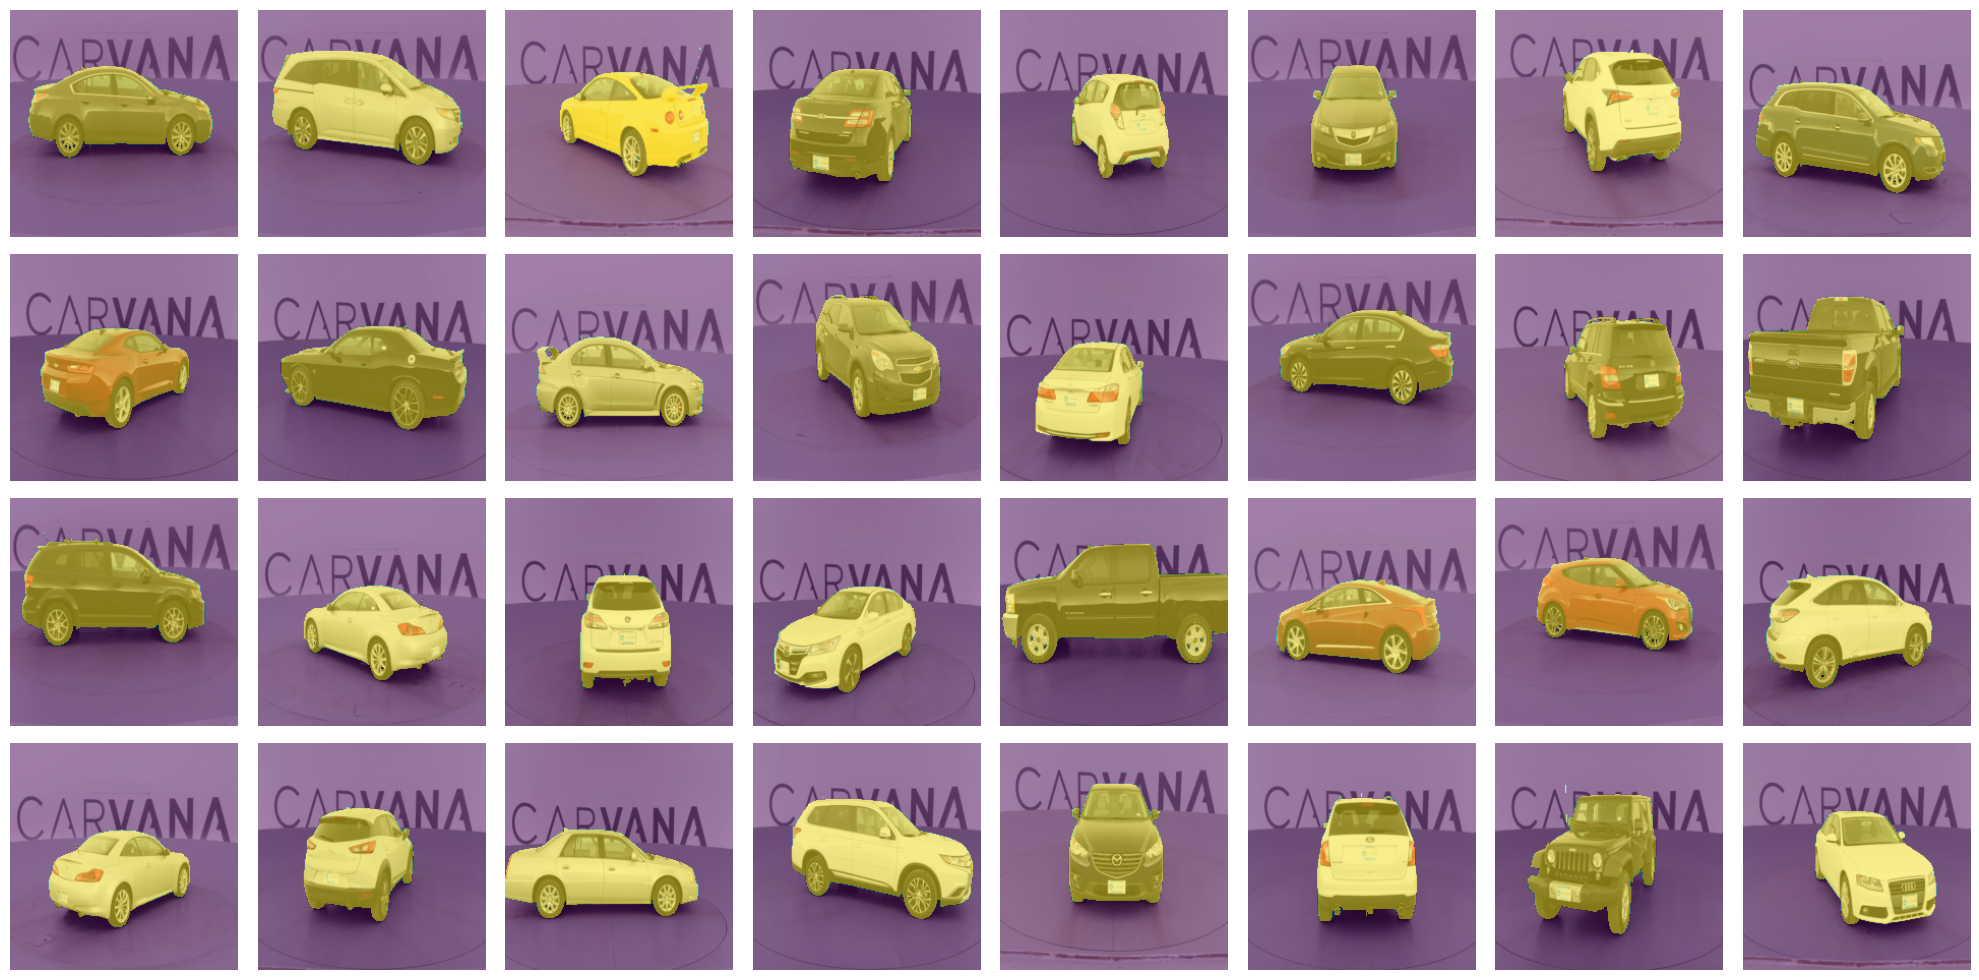

In [29]:
imgs, masks = next(iter(train_loader))

def plot_mini_batch(imgs,masks):
    plt.figure(figsize = (20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4,8,i+1) #i+1 xq plt comienza en 1
        img = imgs[i,...].permute(1,2,0).numpy()
        mask = masks[i,...].permute(1,2,0).numpy()
        plt.imshow(img)
        plt.imshow(mask, alpha= 0.5)

        plt.axis('Off')
    plt.tight_layout()
    plt.show()

plot_mini_batch(imgs, masks)
        

## U-Net

In [30]:
class Conv_3_k(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()  #con esto se inicializa la madre 
        self.conv1 = nn.Conv3d(channels_in, channels_out, kernel_size=3, stride=1,padding=1)  #el paper hace con padding 0
    def forward(self,x):
        return self.conv1(x)

In [31]:
class Double_Conv(nn.Module):
    '''
    Double convolution block for Unet
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()  #con esto se inicializa la madre 
        self.double_conv = nn.Sequential(
                           Conv_3_k(channels_in, channels_out), 
                           nn.BatchNorm3d(channels_out), #el paper no usa batchnorm porque todavia no habia salido, salieron los dos en 2015
                           nn.ReLU(), 
                           Conv_3_k(channels_out, channels_out), 
                           nn.BatchNorm3d(channels_out), 
                           nn.ReLU())
    def forward(self,x):
        return self.double_conv(x)

In [32]:
class Down_Conv(nn.Module):
    '''
    Bloque que aplica doble conv y max pool, para el camino del submuestreo
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()  
        self.encoder =  nn.Sequential(
                        nn.MaxPool3d(2,2),  #kernel de 2x2 y un stride de 2 para que lo divida a la mitad 
                        Double_Conv(channels_in, channels_out)
                        )
    def forward(self,x):
        return self.encoder(x)

In [33]:
class Up_Conv(nn.Module):
    '''
    bloque de sobremuestreo
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()  
        self.upsample_layer =  nn.Sequential(
                               nn.Upsample(scale_factor=2, mode='bicubic'), 
                               nn.Conv3d(channels_in, channels_in//2, kernel_size=1,stride=1)  #a la salida necesitamos tener la mitad de los canales de entrada
                                )
        self.decoder = Double_Conv(channels_in, channels_out)
        
    def forward(self,x1,x2):
        '''
        x1 - es el volumen de sobremuestreo
        x2 - es el volumen que debemso concatenar que viene del submuestreo
        '''
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2,x1], dim = 1) #con dim 1 le indicamos que lo queremos concatenar en la dimension de los canales
        return self.decoder(x)

In [34]:
class UNET(nn.Module):
    '''
    modelo Unet
    '''
    def __init__(self, channels_in, channels,num_classes):
        super().__init__()
        self.first_conv = Double_Conv(channels_in, channels) #64,224,224
        self.down_conv1 = Down_Conv(channels, 2*channels) #128,112,112
        self.down_conv2 = Down_Conv(2*channels, 4*channels) #256,56,56
        self.down_conv3 = Down_Conv(4*channels, 8*channels) #512,28,28

        self.middle_conv = Down_Conv(8*channels, 16*channels) #1024,14,14

        self.up_conv1 = Up_Conv(16*channels, 8*channels) 
        self.up_conv2 = Up_Conv(8*channels, 4*channels) 
        self.up_conv3 = Up_Conv(4*channels, 2*channels) 
        self.up_conv4 = Up_Conv(2*channels, channels) 

        self.last_conv = nn.Conv3d(channels, num_classes, kernel_size=1,stride=1) #mantiene las dimensiones, reduce el numero de mapas de caracteristucas

    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)

        x5 = self.middle_conv(x4)

        u1 = self.up_conv1(x5,x4)
        u2 = self.up_conv2(u1,x3)
        u3 = self.up_conv3(u2,x2)
        u4 = self.up_conv4(u3,x1)

        return self.last_conv(u4)

In [35]:
channels_in = [1,3,128,128,128]
def test():
    x = torch.randn((32,3,224,224))
    model = UNET(3,64,2)
    return model(x)

preds = test()

In [36]:
preds.shape

torch.Size([32, 2, 224, 224])

# Accuaracy

In [37]:
def accuracy(model, loader):
    correct = 0 
    intersection = 0
    denom = 0 
    union = 0 
    total = 0 
    cost = 0 
    model = model.to(device = device)
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device = device, dtype=torch.float32)
            y = y.to(device = device, dtype=torch.long).squeeze(1) #hace un squeeze para sacarle la dimension del canal
            scores = model(x)
            cost = (F.cross_entropy(scores, y)).item()
            #standard accuracy not optimal
            preds = torch.argmax(scores,dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice
            intersection += (preds*y).sum()
            denom = (preds+y).sum()
            dice = 2*intersection/(denom +1e-8)
            # intersection over union 
            union += (preds + y - preds*y).sum()
            iou = intersection/(union+1e-8)

        return cost/len(loader), float(correct)/total, dice, iou


# Train Loop

In [45]:
def train(model, optimiser, scheduler = None, epochs = 100, store_every = 25):
    model = model.to(device = device)
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0 
        train_cost_acum = 0.
        for mb, (x,y) in enumerate(train_loader, start = 1):
            model.train()
            x = x.to(device = device, dtype=torch.float32)
            y = y.to(device = device, dtype=torch.long).squeeze(1) #hace un squeeze para sacarle la dimension del canal
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            if scheduler:           #esto no se que hace pero se supone que actualiza la tasa de aprendisaje 
                scheduler.step()
                
            train_predictions = torch.argmax(scores, dim = 1)
            train_correct_num +=(train_predictions == y).sum()
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()
            if mb%store_every == 0:   #la validacion tarda bastamte, por eso no lo vamos a ahcer en cada iteracion, solo lo vamos a hacer cada 25 iteraciones dentro de acda epoca
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total     #total de pixeles predichos de la manera correcta sobre el total de pixeles 
                train_cost_every = float(train_cost_acum)/mb
                print(f'mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f}, '
                      f'dice: {dice}, iou: {iou}')
                
            
        

In [39]:
# definimos el entrenamiento del modelo

torch.manual_seed(42)
model = UNET(3,4,2)
epochs = 5
optimiser_unet = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.95, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet, max_lr= 1e-1, steps_per_epoch= len(train_loader), 
                                                epochs=epochs, pct_start= 0.43, div_factor=10, final_div_factor=1000, three_phase=True)



In [46]:
train(model, optimiser_unet, scheduler, epochs)

mb: 25, train cost: 0.1932, val cost: 0.0031,train acc: 0.9155, val acc: 0.9657, dice: 37.563846588134766, iou: 0.8523777723312378
mb: 50, train cost: 0.1351, val cost: 0.0018,train acc: 0.9436, val acc: 0.9773, dice: 36.448978424072266, iou: 0.8999655246734619
mb: 75, train cost: 0.1074, val cost: 0.0016,train acc: 0.9557, val acc: 0.9811, dice: 35.94983673095703, iou: 0.9154424071311951
mb: 100, train cost: 0.0915, val cost: 0.0014,train acc: 0.9624, val acc: 0.9821, dice: 37.47482681274414, iou: 0.9207974076271057
mb: 125, train cost: 0.0812, val cost: 0.0012,train acc: 0.9667, val acc: 0.9856, dice: 38.399139404296875, iou: 0.9349656701087952
mb: 25, train cost: 0.0301, val cost: 0.0009,train acc: 0.9881, val acc: 0.9888, dice: 36.514774322509766, iou: 0.9491603970527649
mb: 50, train cost: 0.0291, val cost: 0.0008,train acc: 0.9884, val acc: 0.9892, dice: 37.44630813598633, iou: 0.9504191875457764
mb: 75, train cost: 0.0283, val cost: 0.0009,train acc: 0.9888, val acc: 0.9898, dic

ValueError: Tried to step 641 times. The specified number of total steps is 640

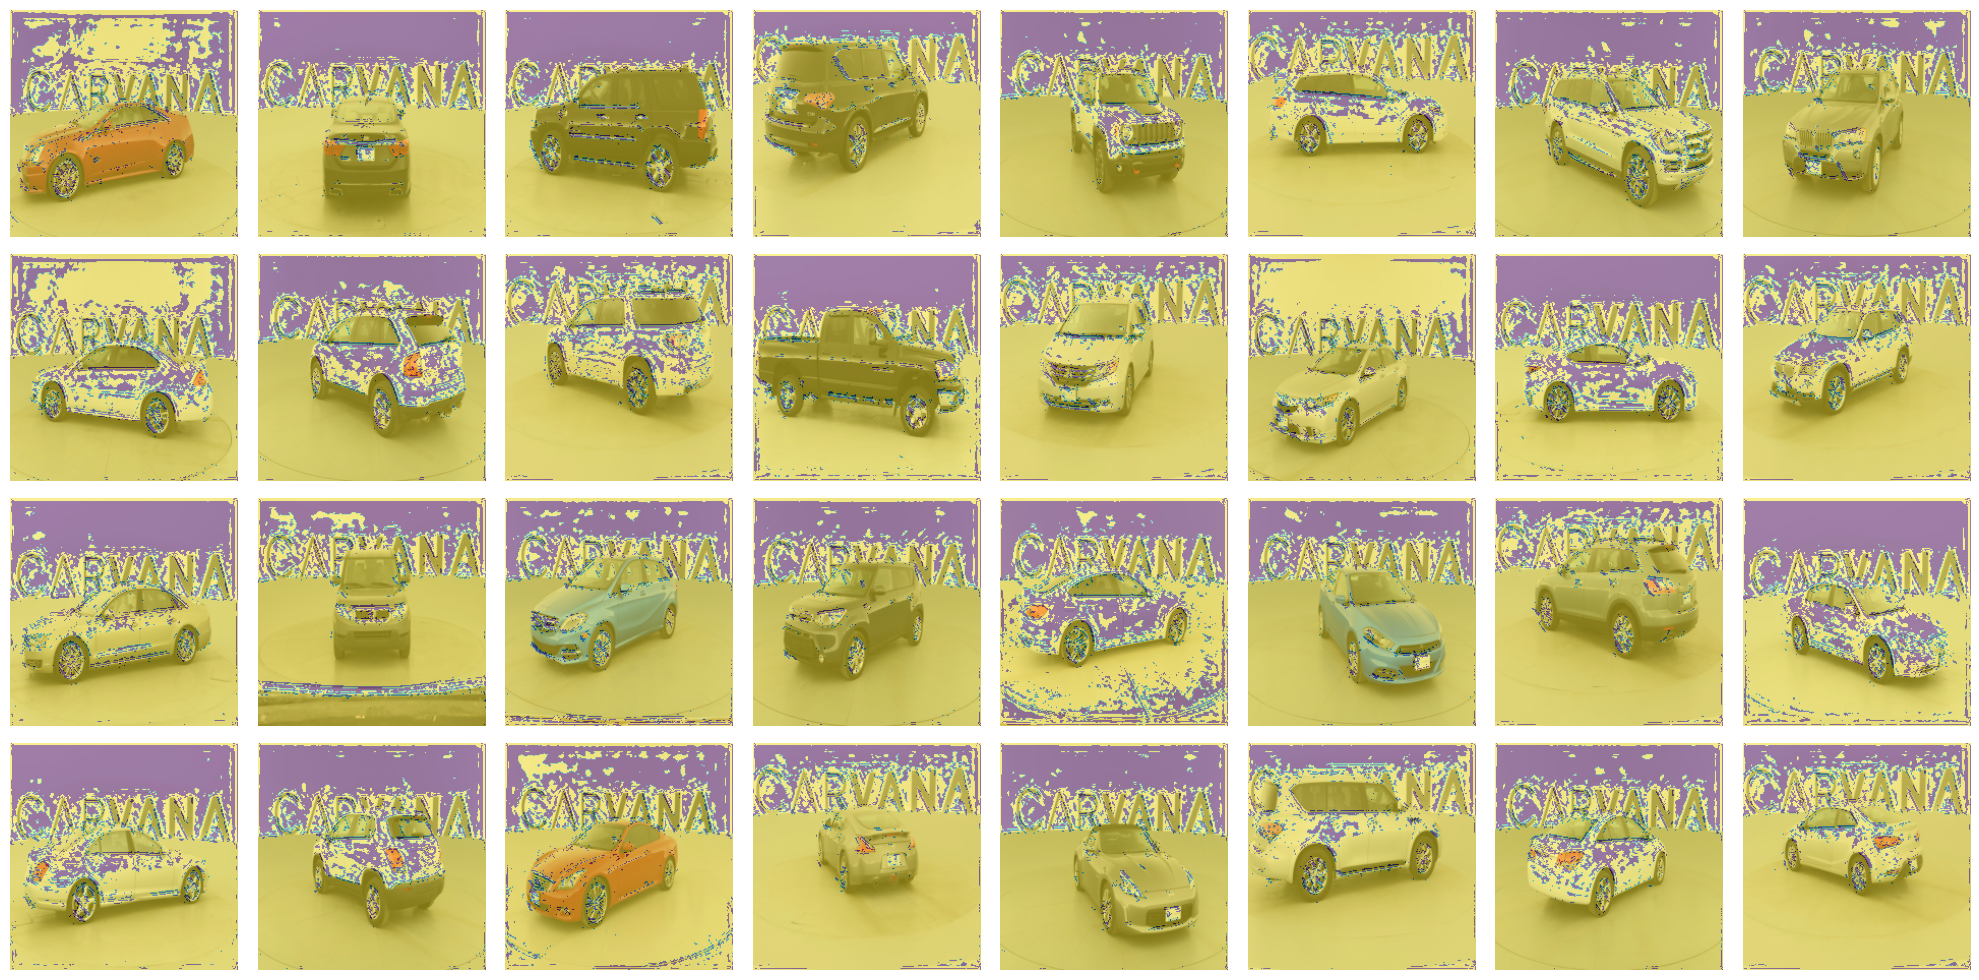

In [40]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype = torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()
plot_mini_batch(imgs_val, preds.unsqueeze(1))
    

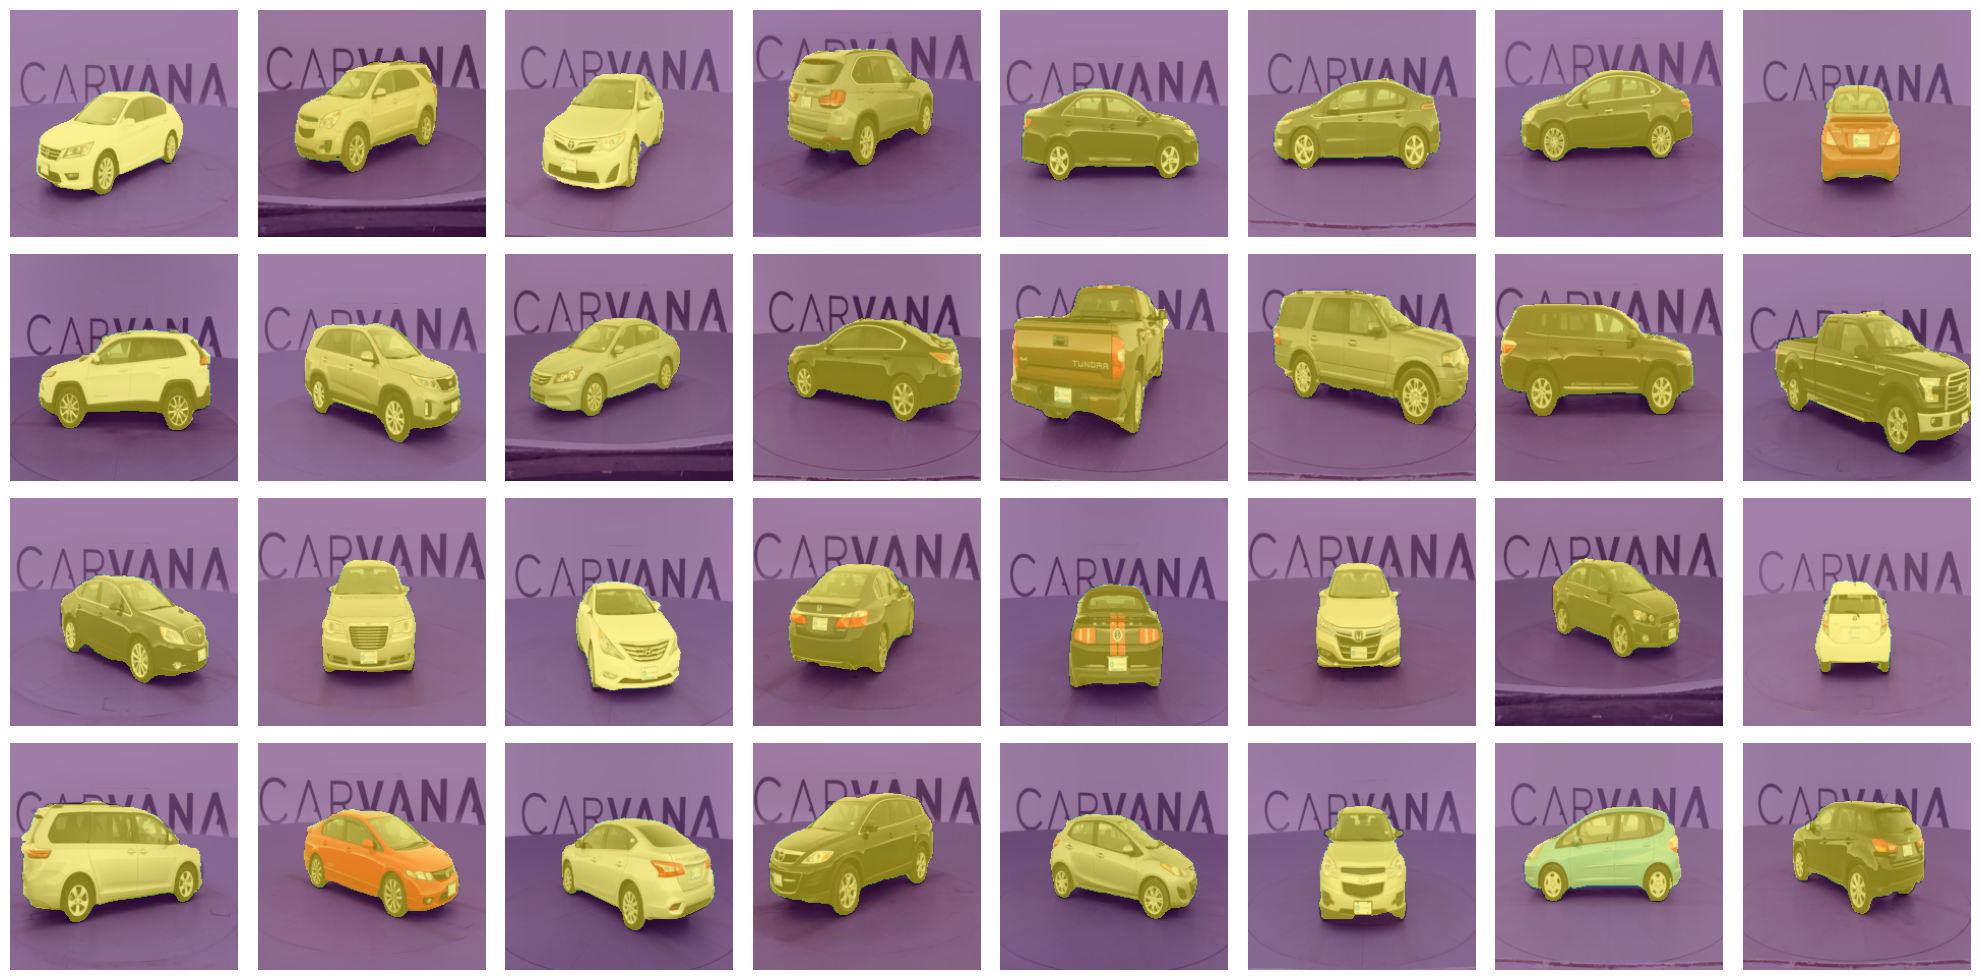

In [47]:
test_set = Car_Dataset(TEST_PATH, img_transforms=transform_data)
test_loader = DataLoader(test_set, batch_size= BATCH_SIZE, shuffle= True)

imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype = torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()
plot_mini_batch(imgs_test, preds.unsqueeze(1))